In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

## Modelling a damped harmonic oscillator based on a classical mechanics system

Original data looks like this:

            t         x
0    0.000000  0.966003
1    0.001001  1.059495
2    0.002002  1.066409
3    0.003003  1.001340
4    0.004004  1.020986
..        ...       ...
995  0.995996  0.086699
996  0.996997  0.086554
997  0.997998  0.083602
998  0.998999  0.080811
999  1.000000  0.079655

[1000 rows x 2 columns]


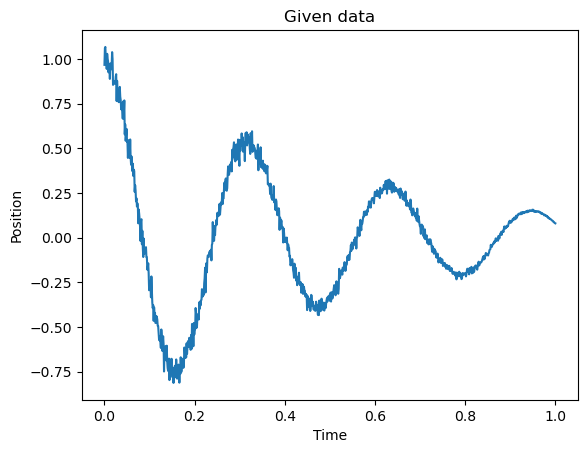

In [3]:
#Used pandas to read csv file
df = pd.read_csv('damped_harmonic_oscillator_data.csv')

t = df['t'].to_numpy()
x = df['x'].to_numpy()
print(df)
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Given data')
plt.show()

In [4]:
T = t.reshape(-1, 1)  # time
X = x.reshape(-1, 1)  # position
print(T[0],X[0])
print(T.shape)

[0.] [0.96600295]
(1000, 1)


We are dividing our data such that the middle 60% is training and the first and last 20% is testing data

In [5]:
#splitting data [40 % testing and 60% training]
#20%(test) ---- 60% (train)--- 20% (test)

marker_1 = int(0.2 * len(df))
marker_2 = int(0.8 * len(df))

# TRAINING DATA
train_data = df.iloc[marker_1:marker_2]
T_train = train_data.iloc[:, :1].to_numpy().reshape(-1, 1)  # time
X_train = train_data.iloc[:, 1:].to_numpy().reshape(-1, 1)  # position

# TESTING DATA
first_half_test = df.iloc[:marker_1]
second_half_test = df.iloc[marker_2:]

test_data = pd.concat([first_half_test, second_half_test])

T_test = test_data.iloc[:, :1].to_numpy().reshape(-1, 1)  # time
X_test = test_data.iloc[:, 1:].to_numpy().reshape(-1, 1)  # position

# Verify shapes
print("Shape of T_train:", T_train.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of T_test:", T_test.shape)
print("Shape of X_test:", X_test.shape)

Shape of T_train: (600, 1)
Shape of X_train: (600, 1)
Shape of T_test: (400, 1)
Shape of X_test: (400, 1)


In [6]:
# Convert numpy arrays to PyTorch tensors
T_train_tensor = torch.tensor(T_train, dtype=torch.float32, requires_grad = True)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad = True)
T_test_tensor = torch.tensor(T_test, dtype=torch.float32, requires_grad = True)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad = True)
print(T_train_tensor.shape)

torch.Size([600, 1])


Defining the neural network

In [7]:
torch.seed()

class SGDRegression(nn.Module):
    def __init__(self, activation_fn):
        super(SGDRegression, self).__init__()
        self.fc1 = nn.Linear(1, 16)  # Input layer [1 input]
        self.fc2 = nn.Linear(16, 16)  # Hidden layer 1
        self.fc3 = nn.Linear(16, 16)  # Hidden layer 2
        self.fc4 = nn.Linear(16, 1)   # Output layer [1 output]
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.fc1(x))  
        x = self.activation_fn(self.fc2(x)) 
        x = self.activation_fn(self.fc3(x))  
        x = self.fc4(x)
        return x


We are using tensorboard to record within training

In [8]:
pip install tensorboardX

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In order to calculate physical loss, we need a certain amount of sample points along our data. Here, we are obtaining 20% of the total data for calculating this loss

In [9]:
# Extract x% of training data for physical loss calculation

N = int(0.2 * len(T)) 

physical_indices = np.random.choice(len(T), 400, replace=False) #choosing the random points

T_physical_tensor1 = torch.tensor(T[physical_indices], dtype = torch.float32, requires_grad = True)
X_physical_tensor = torch.tensor(X[physical_indices], dtype = torch.float32, requires_grad = True)

print(T_physical_tensor1.shape)
#print(X_physical_tensor.shape)


time_values2 = np.linspace(0, 2, 200).reshape(-1,1)

T_physical_tensor2 = torch.tensor(time_values2, dtype = torch.float32, requires_grad = True)

print(T_physical_tensor2.shape)

torch.Size([400, 1])
torch.Size([200, 1])


Our loss function has constants converted into learnable parameters and returns a mean squared error loss on the positions as well as a physics loss calculated using the force body equations. We can use exponents, square root, etc. to enhance the rate of the constants learning. 

In [10]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__() #add mass = 1 mu = 40 and k = 400 as input parameters. 
        self.mse_fn = torch.nn.MSELoss()
        self.phys_const1 = torch.nn.Parameter(torch.rand(1))
        self.phys_const2 = torch.nn.Parameter(torch.rand(1))

    def forward(self, X_pred, output_data, phys_inputs, phys_preds):
        # data driven loss
        loss_data = self.mse_fn(X_pred, output_data)
        
        # physics driven loss
        dy = torch.autograd.grad(phys_preds, phys_inputs, torch.ones_like(phys_preds), create_graph=True)[0]
        dy2 = torch.autograd.grad(dy, phys_inputs, torch.ones_like(dy), create_graph=True)[0]
        
        loss_phys = dy2 + torch.exp(self.phys_const1)*dy + torch.exp(self.phys_const2)*phys_preds
        loss_phys = (1/torch.exp(self.phys_const2)) * loss_phys
        loss_phys = torch.mean(loss_phys**2)
        
        return loss_data, loss_phys
    
#compute loss within training

Here, we have the true values of constants that were experimentally calculated

In [11]:
m = 1.0  #mass
mu = 4   #viscosity
k = 400  #spring constant
true_const1 = np.log(mu/m)
true_const2 = np.log(k/m)
#loss_phys = dy2 + (mu/m) * dy + (k/m)* phys_preds = 0
print(true_const1, true_const2)

1.3862943611198906 5.991464547107982


Within training, we implemented mini-batch gradient descent, and are factoring in total loss with a weighted proportion alpha.

In [ ]:
from tensorboardX import SummaryWriter
import itertools

BATCH_SIZE = 8 #16
EPOCHS = 1500
LR = 0.001

train_data = torch.utils.data.TensorDataset(T_train_tensor, X_train_tensor)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

writer = SummaryWriter()
size = len(data_loader.dataset)

custom_loss = CustomLoss()
loss_trainable_params = sum(p.numel() for p in custom_loss.parameters() if p.requires_grad)
print("Loss trainable parameters:", loss_trainable_params)

activation_name = "Tanh"
activation_fn = torch.tanh
model = SGDRegression(activation_fn)

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), custom_loss.parameters()), lr=LR)
losses = []
data_losses = []
phys_losses = []

const1 = []
const2 = []
alpha = 0.7

for epoch in range(EPOCHS):
    epoch_losses = []
    for batch, (input_data, output_data) in enumerate(data_loader):

        phys_preds = model(T_physical_tensor2) #same model for both?
        X_pred = model(input_data)

        # Compute loss
        mse_loss, physical_loss = custom_loss(X_pred, output_data, T_physical_tensor2, phys_preds)
        
        # Combine losses
        loss = (1 - alpha) * mse_loss + alpha * physical_loss       

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        data_losses.append(mse_loss.item())
        phys_losses.append(physical_loss.item())

        train_step = epoch*size + batch
        
        const1.append(custom_loss.phys_const1)
        const2.append(custom_loss.phys_const2)
        # writer.add_scalar("(Exp)Phys/1", custom_loss.phys_const1, train_step)
        # writer.add_scalar("(Exp)Phys/2", custom_loss.phys_const2, train_step)
        # writer.add_scalar("(Exp)Loss/Data", mse_loss.item(), train_step)
        # writer.add_scalar("(Exp)Loss/Physics", physical_loss.item(), train_step)
        
        #writer.add_histogram("Gradient", custom_loss.phys_const1.grad.cpu(), train_step)
    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)
    #writer.add_scalar("(Exp)Loss/Total", avg_epoch_loss.item(), train_step) 
        
print("Done")

writer.close()

In [13]:
custom_loss.phys_const1
c1_array = [param.detach().numpy().tolist() for param in const1]
c2_array = [param.detach().numpy().tolist() for param in const2]
print(c1_array[:10])

[[1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814], [1.475176215171814]]


Plotting the loss function

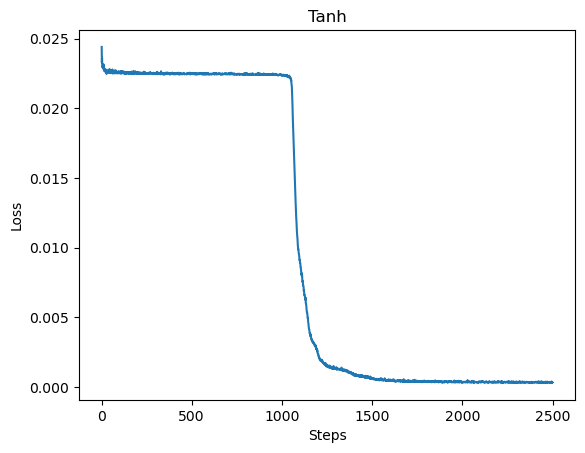

In [14]:
L = list(range(1, len(losses) + 1))
plt.plot(L, losses)
plt.title("Tanh")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

Comparing the physics loss to the data driven loss

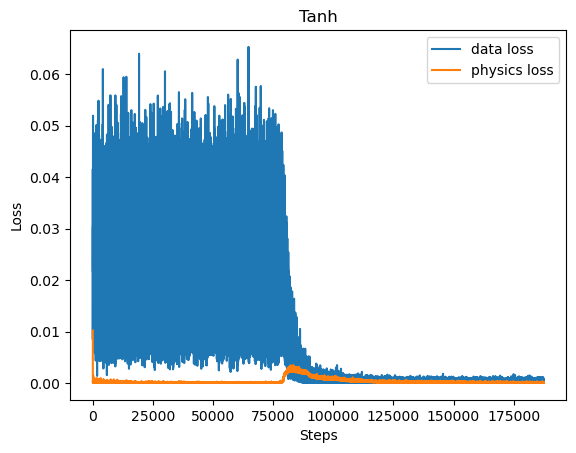

In [15]:
l = list(range(1, len(data_losses) + 1)) #add (1-alpha) and (alpha) for proportional graph
ndata_losses = np.array(data_losses)
nphysics_losses = np.array(phys_losses)
plt.plot(l, (1 - alpha) * ndata_losses, label = "data loss")
plt.plot(l, alpha * nphysics_losses , label = "physics loss")
plt.title("Tanh")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

To evaulate this model, we plot the actual posiitons with respect to time as well as the predicted positions on both training and testing

0.0016399656081946853


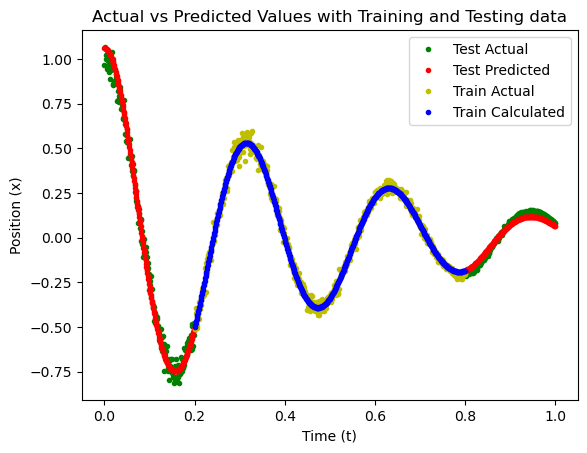

In [17]:
#Evaluating
model.eval()

#time_values = np.linspace(1, 2, 1000)  # 1000 points b/w t = 1 to t = 2
#time_tensor = torch.tensor(time_values.reshape(-1, 1), dtype=torch.float32, requires_grad = True)

with torch.no_grad():
    X_test_pred = model(T_test_tensor)
    X_train_pred = model(T_train_tensor)
    #predicted_positions = model(time_tensor)
    
X_test_pred = X_test_pred.numpy()
X_train_pred = X_train_pred.numpy()
#predicted_positions = predicted_positions.numpy()

mean_square_error = np.mean((X_test_pred - X_test)**2)
print(mean_square_error)
 



# Plot actual vs predicted values
plt.plot(T_test, X_test, 'g.', label='Test Actual')
plt.plot(T_test, X_test_pred,'r.', label='Test Predicted')
plt.plot(T_train, X_train, 'y.', label='Train Actual')
plt.plot(T_train, X_train_pred,'b.', label='Train Calculated')

#plt.plot(time_values, predicted_positions, label='Predicted Position')

plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.title('Actual vs Predicted Values with Training and Testing data')
plt.legend()
plt.show()